Countries found: ['China' 'Germany' 'India' 'United States']
Year range: 1970 - 2021

Sample data:
      Country  Year  Gross Domestic Product (GDP)
1948   China  1970                  9.260262e+10
1949   China  1971                  9.980058e+10
1950   China  1972                  1.140000e+11
1951   China  1973                  1.390000e+11
1952   China  1974                  1.440000e+11


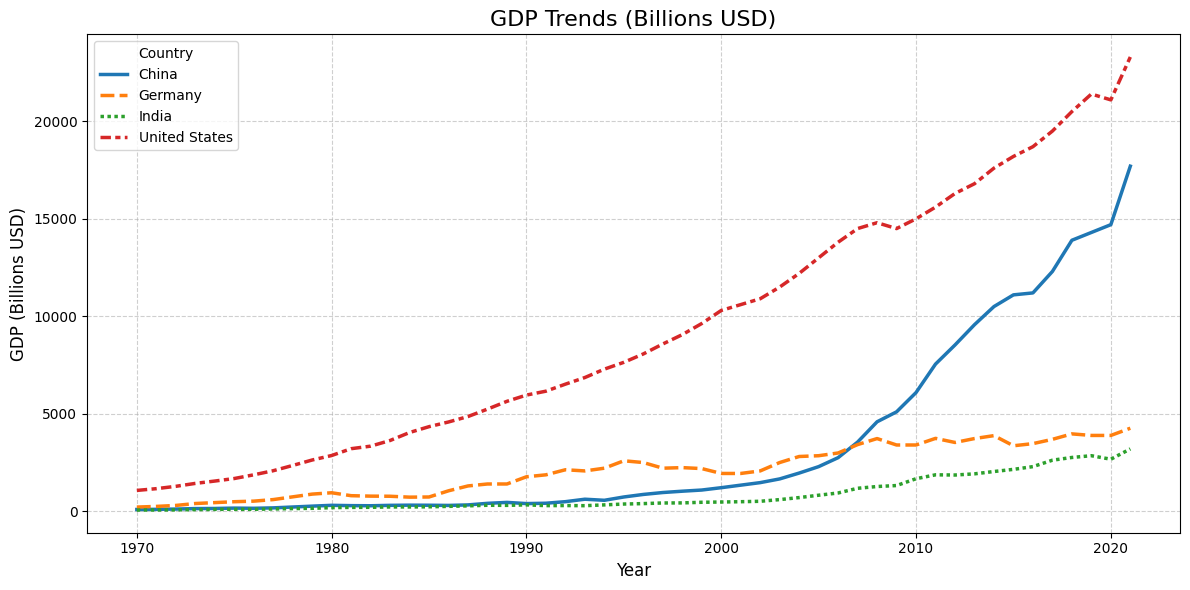

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and clean data
file_path = "/Users/vijaykrishnareddy/Documents/ESDS - 2ND SEM/SDM2/Project/Global Economy Indicators.csv"
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()

# Clean country names (remove spaces)
df['Country'] = df['Country'].str.strip()

# Define countries to plot (match EXACTLY with cleaned names)
countries = ["United States", "China", "India", "Germany"]
country_col = "Country"
year_col = "Year"
gdp_col = "Gross Domestic Product (GDP)"

# Filter data
gdp_data = df[df[country_col].isin(countries)][[country_col, year_col, gdp_col]].dropna()

# Convert GDP to numeric (handling commas, etc.)
gdp_data[gdp_col] = pd.to_numeric(gdp_data[gdp_col].astype(str).str.replace(',', ''), errors='coerce')
gdp_data = gdp_data.dropna(subset=[gdp_col])

# Check results
print("Countries found:", gdp_data[country_col].unique())
print("Year range:", gdp_data[year_col].min(), "-", gdp_data[year_col].max())
print("\nSample data:\n", gdp_data.head())

# Pivot and plot
plt.figure(figsize=(12, 6))
gdp_pivot = gdp_data.pivot(index=year_col, columns=country_col, values=gdp_col)
gdp_pivot = gdp_pivot/1e9  # Convert to billions for readability

sns.lineplot(data=gdp_pivot, linewidth=2.5)
plt.title('GDP Trends (Billions USD)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('GDP (Billions USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Country')
plt.tight_layout()
plt.show()

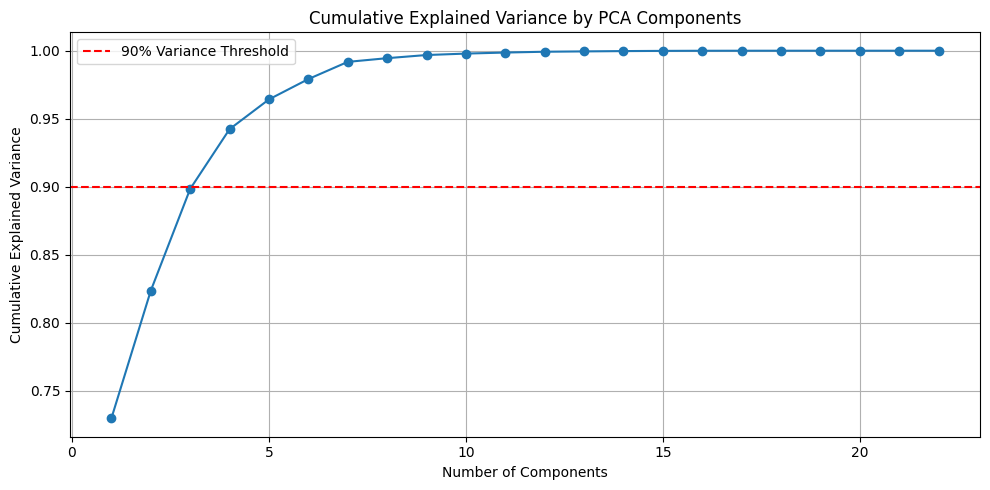

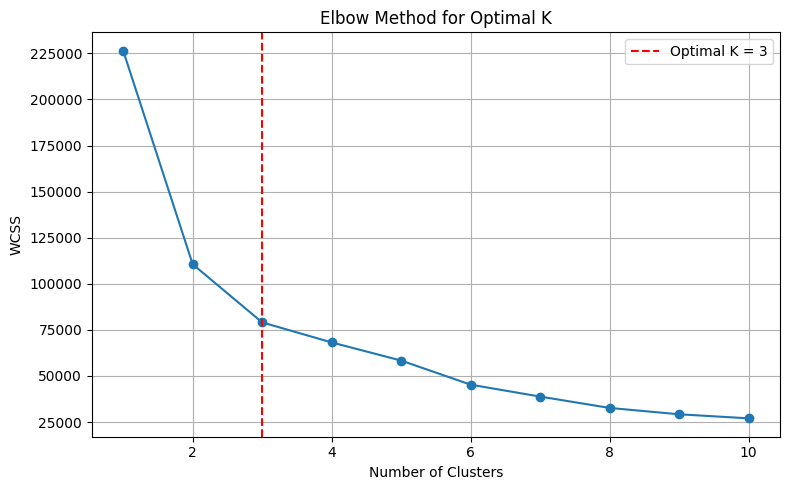

Cluster  Country                          
0        Afghanistan                          52
         Albania                              52
         Algeria                              52
         Andorra                              52
         Angola                               52
         Anguilla                             52
         Antigua and Barbuda                  52
         Argentina                            52
         Armenia                              32
         Aruba                                52
         Australia                            49
         Austria                              52
         Azerbaijan                           32
         Bahamas                              52
         Bahrain                              52
         Bangladesh                           52
         Barbados                             52
         Belarus                              32
         Belgium                              52
         Belize           

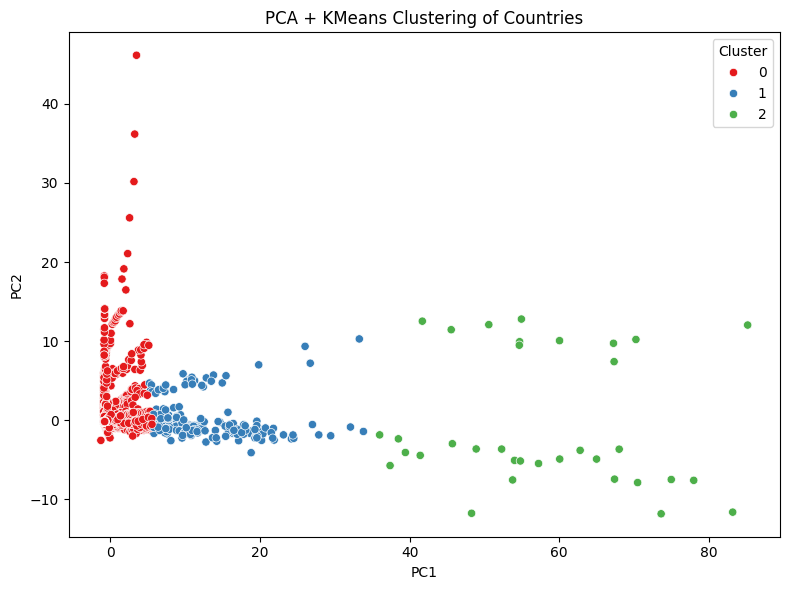

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import seaborn as sns

# Load the dataset
df = pd.read_csv("/Users/vijaykrishnareddy/Documents/ESDS - 2ND SEM/SDM2/Project/Global Economy Indicators.csv")
df.columns = df.columns.str.strip()

# Drop any constant columns, EXCEPT important identifiers
constant_cols = [col for col in df.columns if df[col].nunique() == 1 and col not in ['Country', 'Currency', 'CountryID']]
df = df.drop(columns=constant_cols)

# Drop non-numeric columns for PCA but keep 'Country' and 'Year' for later use
non_numeric_cols = ['Country', 'Currency', 'Year', 'CountryID']
numeric_df = df.drop(columns=non_numeric_cols)

# Handle missing values (impute with mean)
imputer = SimpleImputer(strategy='mean')
numeric_imputed = imputer.fit_transform(numeric_df)

# Standardize the data
scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(numeric_imputed)

# Perform PCA
pca = PCA()
pca_data = pca.fit_transform(numeric_scaled)

# Plot explained variance to determine components
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), 
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)

# Mark cutoff threshold for variance (~90%)
threshold = 0.90
plt.axhline(y=threshold, color='r', linestyle='--', label=f'90% Variance Threshold')
plt.legend()

# Save the plot
plt.tight_layout()
plt.savefig('Cumulative Explained Variance by PCA Components.png') 

# Show the plot
plt.show()

# Retain enough components to explain ~90% variance (adjust as needed)
n_components = 6  # You can adjust this based on the plot observation
pca = PCA(n_components=n_components)
pca_data = pca.fit_transform(numeric_scaled)

# Elbow method for K-means
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_data)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.tight_layout()
plt.grid(True)

# Mark cutoff threshold (optimum 'k' value)
optimal_k = 3  # Based on your analysis and elbow plot
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal K = {optimal_k}')
plt.legend()

# Save the plot
plt.savefig('Elbow Method for Optimal K.png') 
plt.show()

# Choose optimal k (e.g., 3)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pca_data)

# Add cluster labels back to original df
df['Cluster'] = clusters
df_with_clusters = df[['Country', 'Year', 'Cluster']].copy()

# View sample of clustered countries
print(df_with_clusters.groupby(['Cluster', 'Country']).size().head(50))

# Optional: visualize PCA clusters (first 2 components)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=clusters, palette='Set1')
plt.title('PCA + KMeans Clustering of Countries')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.tight_layout()

# Save the clustering plot
plt.savefig('pca_kmeans_clustering.png')
plt.show()
